# CNN Classifier for Plant Waves 
----

#### PREPROCESSING: Create MFCC Images 
In this step, we compute the MFCC matrix, create MFCC images, reshape it to 224x224 images, and store them to disk with labels corresponding to classes and the number of sample. 

In [ ]:
import numpy as np
import torch
import pickle
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from python_speech_features import mfcc
from PIL import Image
from tqdm import tqdm

%run ../src/utils/constants.py

Load raw data that has been split into train, test, and validation sets for the 81k and 191k cases.

In [ ]:
path_to_pickle_train81k = DATASETS_DIR / "train-81k-stratified-without-neutral.pkl"
path_to_pickle_train191k = DATASETS_DIR / "train-191k-stratified-without-neutral.pkl"
path_to_pickle_test81k = DATASETS_DIR / "test-81k-stratified-without-neutral.pkl"
path_to_pickle_val81k = DATASETS_DIR / "val-81k-stratified-without-neutral.pkl"

In [ ]:
with open(path_to_pickle_train81k, 'rb') as train_81k_file:
    train_81k = pickle.load(train_81k_file)

In [ ]:
with open(path_to_pickle_train191k, 'rb') as train_191k_file:
    train_191k = pickle.load(train_191k_file)

In [ ]:
with open(path_to_pickle_test81k, 'rb') as test_81k_file:
    test_81k = pickle.load(test_81k_file)

In [ ]:
with open(path_to_pickle_val81k, 'rb') as val_81k_file:
    val_81k = pickle.load(val_81k_file)

While ignoring the class `Neutral`, separate wave slices and labels, and create a Tensor dataset. 

In [ ]:
wav_slices = []
labels = []
for segment in train_191k:  # adjust this iterable for specific dataset.
    wav_slices.append(segment[0])
    labels.append(segment[1])

In [ ]:
wav_slices = torch.tensor(np.array(wav_slices), dtype=torch.float32)
labels = torch.tensor(np.array(labels), dtype=torch.long)
dataset = TensorDataset(wav_slices, labels)
print(wav_slices)

Normalize the samples using per-sample normalization.

In [ ]:
data_tensor, labels_tensor = dataset.tensors
mean = torch.mean(data_tensor, dim=1, keepdim=True)
std_dev = torch.std(data_tensor, dim=1, keepdim=True)
standardized_data = (data_tensor - mean) / (std_dev + 0.00000001)  # smoothing term to prevent zero division

dataset = TensorDataset(standardized_data, labels_tensor)

Extract the MFCC features and save the MFCC plots to disk as `.png`. Create the lists `ids`, `features`, `labels` to be able to split MFCC images into train, test, val datasets as done for the FCNN case. 


In [ ]:
train_81k_folder = "train-81k"
train_191k_folder = "train-191k"
test_81k_folder = "test-81k"
val_81k_folder = "val-81k"

In [ ]:
if not os.path.exists(MFCC_IMAGES_DIR / train_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / train_81k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / train_191k_folder):
    os.mkdir(MFCC_IMAGES_DIR / train_191k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / test_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / test_81k_folder)

if not os.path.exists(MFCC_IMAGES_DIR / val_81k_folder):
    os.mkdir(MFCC_IMAGES_DIR / val_81k_folder)

In [ ]:
count = 0 
for wav_slice, label in tqdm(dataset):
    mfcc_features = mfcc(wav_slice, samplerate=10000, winlen=0.025, winstep=0.010, numcep=26)

    file_name = f"{count}_mfcc_class_{label}.png"
    save_path = os.path.join(MFCC_IMAGES_DIR / train_191k_folder, file_name)  # Adjust train_191k_folder

    if not os.path.exists(save_path):
        plt.imshow(mfcc_features)
        plt.axis("off")
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
    count += 1

----
#### PREPROCESSING: LOAD MFCC Images
Prepare the train data for the CNN.

In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


%run ../src/utils/constants.py

In [2]:
train_81k_folder = "train-81k"
#train_191k_folder = "train-191k"

In [3]:
# Load all MFCC images and file names. 
images_train = []
labels_train = []

image_filenames = os.listdir(MFCC_IMAGES_DIR / train_81k_folder)
image_paths = [os.path.join(MFCC_IMAGES_DIR / train_81k_folder, filename) for filename in image_filenames]

IMAGE_SIZE = (97,97)
N_CHANNELS = 3  # rgb
for path in tqdm(image_paths): 
    file_name = os.path.basename(path)
    label_train = int(file_name.split(".")[0].split("_")[-1])    
    img = Image.open(path).convert("L")  # Make sure it is rgb (and not rgba which would give dim=4)
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0
    images_train.append(img_array)
    labels_train.append(label_train)

100%|███████████████████████████████████| 12130/12130 [00:35<00:00, 343.22it/s]


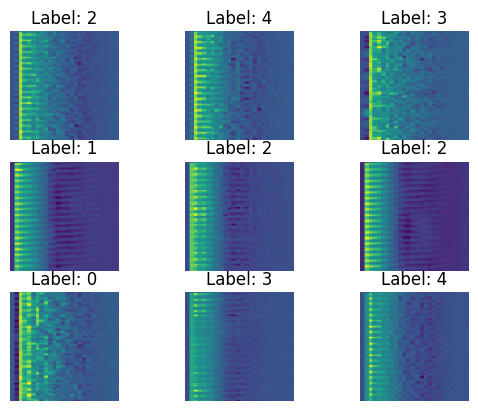

In [4]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_train[i])
    plt.title(f"Label: {labels_train[i]}")  # TODO: adjust this so that class label is extracted from file label. 
    plt.axis("off")
plt.show()

Prepare the val data for the CNN.

In [5]:
val_81k_folder = "val-81k"

In [6]:
# Load all MFCC images and file names. 
images_val = []
labels_val = []

image_filenames_val = os.listdir(MFCC_IMAGES_DIR / val_81k_folder)
image_paths_val = [os.path.join(MFCC_IMAGES_DIR / val_81k_folder, filename_val) for filename_val in image_filenames_val]

IMAGE_SIZE = (97,97)
N_CHANNELS = 3  # rgb
for path_val in tqdm(image_paths_val): 
    file_name_val = os.path.basename(path_val)
    label_val = int(file_name_val.split(".")[0].split("_")[-1])    
    img_val = Image.open(path_val).convert("L")  # convert to greyscale
    img_val = img_val.resize(IMAGE_SIZE)
    img_array_val = np.array(img_val) / 255.0
    images_val.append(img_array_val)
    labels_val.append(label_val)

100%|█████████████████████████████████████| 2600/2600 [00:08<00:00, 317.84it/s]


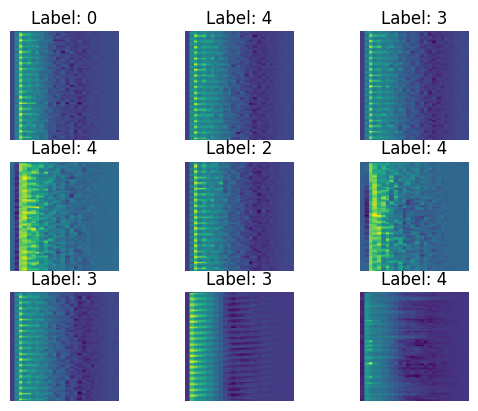

In [7]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_val[i])
    plt.title(f"Label: {labels_val[i]}")  # TODO: adjust this so that class label is extracted from file label. 
    plt.axis("off")
plt.show()

Create datasets and dataloaders.

In [8]:
images_train = torch.tensor(np.array(images_train), dtype=torch.float32)
images_train = images_train.unsqueeze(1)
labels_train = torch.tensor(np.array(labels_train), dtype=torch.long)
train81k_dataset = TensorDataset(images_train, labels_train)

images_val = torch.tensor(np.array(images_val), dtype=torch.float32)
images_val = images_val.unsqueeze(1)
labels_val = torch.tensor(np.array(labels_val), dtype=torch.long)
val81k_dataset = TensorDataset(images_val, labels_val)

In [9]:
batch_size = 32
train81k_loader = DataLoader(train81k_dataset, batch_size)
val81k_loader = DataLoader(val81k_dataset, batch_size)

#### Hyperparameter Optimization
Specify a study name and define the search space for the grid search. 

Run `PREPROCESSING: LOAD MFCC Images`.

In [11]:
import torch
import wandb
import optuna
import math
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

Define the CNN model.

In [12]:
def define_model(trial):
    layers = []

    N_CLASSES = 6
    conv_kernel_size = trial.suggest_categorical(f"conv_kernel_size", [3, 5])
    dropout_rate = trial.suggest_categorical("dropout_rate", [0.0, 0.1, 0.2])


    input_channels = 1
    out_channels_l1 = trial.suggest_categorical(f"out_channels_l1", [2 ** i for i in range(5, 8)])
    
    layers.append(torch.nn.Conv2d(input_channels, out_channels_l1, kernel_size=conv_kernel_size))
    hidden_img_height = IMAGE_SIZE[0] - conv_kernel_size + 1
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1
    layers.append(torch.nn.Dropout(dropout_rate))

    out_channels_l2 = trial.suggest_categorical(f"out_channels_l2", [2 ** i for i in range(5, 7)])

    layers.append(torch.nn.Conv2d(out_channels_l1, out_channels_l2, kernel_size=conv_kernel_size))
    hidden_img_height = hidden_img_height - conv_kernel_size + 1
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
    hidden_img_height = math.floor((hidden_img_height - 2) / 2) + 1
    layers.append(torch.nn.Dropout(dropout_rate))

    layers.append(torch.nn.Flatten())

    layers.append(torch.nn.Linear(out_channels_l2 * hidden_img_height * hidden_img_height, 64))  # Likely wrong...
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(64, N_CLASSES))

    config_dict = {
        "out_channels_l1": out_channels_l1,
        "out_channels_l2": out_channels_l2,
        "conv_kernel_size": conv_kernel_size,
        "dropout_rate": dropout_rate
    }

    return torch.nn.Sequential(*layers), config_dict

Define the objective function for optuna for the hyperparameter optimization.

In [13]:
def objective(trial): 
    model, config_dict = define_model(trial)

    lr = trial.suggest_categorical('lr', [0.0001, 0.001, 0.01])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(config_dict)
    name_experiment = (f"{trial.number}_{NAME_CORE}_lr-{lr}_convf1-{config_dict['out_channels_l1']}_convf2-"
                       f"{config_dict['out_channels_l2']}_convker-{config_dict['conv_kernel_size']}_dr-{config_dict['dropout_rate']}")

    config_dict["lr"] = lr
    config_dict["epochs"] = NUM_EPOCHS

    wandb.init(
        project="model_" + NAME_CORE + "-hpo",
        dir=LOGS_DIR,
        name=name_experiment,
        config=config_dict
    )


    for epoch in range(NUM_EPOCHS):
        model.train()
        for batch_data, batch_labels in tqdm(train81k_loader):          
            # zero gradients
            optimizer.zero_grad()

            # forward + backward pass
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

        all_preds = []
        all_labels = []

        model.eval()
        with torch.no_grad():
            for batch_data, batch_labels in tqdm(val81k_loader): 
                output = model(batch_data)

                predicted = output.argmax(dim=1)
                all_preds.extend(predicted.numpy())
                all_labels.extend(batch_labels.numpy())

        # TODO: explicitely state in written thesis that zero_division=0.0
        balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        f1_class = f1_score(all_labels, all_preds, average=None, zero_division=0.0)
        f1_weighted = f1_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0.0)
        precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0.0)

        trial.report(balanced_accuracy, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

            
        metrics = {
            "balanced_accuracy": balanced_accuracy,
            "accuracy": accuracy,
            "f1_weighted": f1_weighted,
            "recall": recall,
            "precision": precision
        }

        wandb_input = metrics
        wandb.log(wandb_input)

    wandb.finish()

    return balanced_accuracy

Run hyperparameter optimization using optuna. 

In [14]:
NAME_CORE = "cnn_mfcc_6_rgb_81k"
NUM_EPOCHS = 15

In [15]:
search_space = {
    'lr': [0.0001, 0.001, 0.01],
    'out_channels_l1': [2 ** i for i in range(5, 8)],   # 3 values
    'out_channels_l2': [2 ** i for i in range(5, 7)],   # 2 values
    'conv_kernel_size': [3, 5],
    "dropout_rate": [0.0, 0.1, 0.2]
}

In [ ]:
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(sampler=sampler, study_name=NAME_CORE, storage="sqlite:///hpo_" + NAME_CORE + ".db",
                            direction="maximize", load_if_exists=True)
study.optimize(objective, n_trials=108)

Closer look into the trials. 

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial_ = study.best_trial

print("  Value: ", trial_.value)
print("  Params: ")
for key, value in trial_.params.items():
    print("    {}: {}".format(key, value))

#### Training the CNN.
10 times training with best HP from HPO, and then average. 

#### Testing the Classifier

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

%run ../src/utils/constants.py

In [ ]:
test_81k_folder = "test-81k"

In [ ]:
# Load all MFCC images and file names. 
images_test = []
labels_test = []

image_filenames_test = os.listdir(MFCC_IMAGES_DIR / test_81k_folder)
image_paths_test = [os.path.join(MFCC_IMAGES_DIR / test_81k_folder, filename_test) for filename_test in image_filenames_test]

IMAGE_SIZE = (97,97)
N_CHANNELS = 3  # rgb
for path_test in tqdm(image_paths_test): 
    file_name_test = os.path.basename(path_test)
    label_test = int(file_name_test.split(".")[0].split("_")[-1])    
    img_test = Image.open(path_test)
    img_test = img_test.resize(IMAGE_SIZE)
    img_array_test = np.array(img_test) / 255.0
    images_test.append(img_array_test)
    labels_test.append(label_test)

In [ ]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_test[i])
    plt.title(f"Label: {labels_test[i]}")  # TODO: adjust this so that class label is extracted from file label. 
    plt.axis("off")
plt.show()

In [ ]:
images_test = torch.tensor(np.array(images_test), dtype=torch.float32)
labels_test = torch.tensor(np.array(labels_test), dtype=torch.long)
test81k_dataset = TensorDataset(images_test, labels_test)

In [ ]:
batch_size = 32
test81k_loader = DataLoader(test81k_dataset, batch_size)